In [85]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors
from numba import jit
from scipy import sparse
import pandas as pd

In [86]:
df = pd.read_csv('combined_peaks_named.csv')
df.describe()

,peak_area,RT1_center,RT2_center,RT1_start,RT2_start,RT1_end,RT2_end,m/z,class
count,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,7.295166e+05,7280.061889,1.527361,7279.895611,1.556528,7281.432667,1.494111,194.075231,0.658565
std,2.471182e+06,2000.966258,0.425301,2000.837822,0.432232,2001.059576,0.418226,106.740750,0.474466
min,1.501200e+04,2953.360000,1.008000,2953.360000,1.024000,2953.360000,0.976000,30.000000,0.000000
25%,6.932407e+04,5987.824000,1.176000,5987.824000,1.200000,5987.824000,1.144000,116.000000,0.000000
50%,2.107435e+05,7529.584000,1.420000,7529.584000,1.448000,7529.584000,1.384000,168.000000,1.000000
75%,6.333406e+05,9074.848000,1.880000,9074.848000,1.906000,9074.848000,1.824000,248.000000,1.000000
max,4.985909e+07,11103.664000,3.472000,11103.664000,3.496000,11103.664000,3.440000,671.000000,1.000000


In [87]:
def gradient_calculator_gaussian_kde(x, data, bandwidth):
    D = data.shape[1]
    N = data.shape[0]
    grad = np.zeros((1, D))

    h = bandwidth

    C = 1/(N*h**D * np.sqrt(2*np.pi)**D)
    F = -1/(2*h**2)
    for i in range(D):
        for n in range(N):
            grad[0, i] += 2 * C * F * (x[i] - data[n, i]) * np.exp(F * np.sum((x - data[n])**2))
    
    return grad

In [88]:
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

df1 = df[df['class'] == 0]
df2 = df[df['class'] == 1]

features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

# Normalize all features
scaler = StandardScaler()
scaler.fit(features_all)
biotic_peaks_normalized = scaler.transform(features_class1_)
abiotic_peaks_normalized = scaler.transform(features_class0_)


# Define the bandwidth values to test
bandwidths = np.linspace(0.1, 1.0, 30)

# Set up the grid search
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation

# Fit the grid search
grid.fit(biotic_peaks_normalized)

# Get the best bandwidth
best_bandwidth = grid.best_estimator_.bandwidth
print(f"Best bandwidth: {best_bandwidth}")

# Fit KDE with the best bandwidth
kde = KernelDensity(bandwidth=best_bandwidth, kernel='gaussian')
kde.fit(biotic_peaks_normalized)
best_bandwidth

Best bandwidth: 0.19310344827586207


0.19310344827586207

In [89]:
import multiprocessing as mp
from functools import partial

def parallel_gradient_calculation(features, biotic_peaks_normalized, best_bandwidth):
    with mp.Pool() as pool:
        gradient_calculator = partial(gradient_calculator_gaussian_kde, 
                                      data=biotic_peaks_normalized, 
                                      bandwidth=best_bandwidth)
        gradients = pool.map(gradient_calculator, features)
    return np.array(gradients).reshape(-1, 3)

In [10]:
# 'Learning' rate - controls how influential gradients are
alpha = 1e-3

gradients_at_time_t = []

points_at_time_t = []

# Initialization

features = abiotic_peaks_normalized.copy()

time_steps = 10000
for t in range(time_steps):
    # Compute gradient and move in that direction
    gradients = parallel_gradient_calculation(features, biotic_peaks_normalized, best_bandwidth)

    # Prevent exploding gradients due to approximation error
    # gradients = np.clip(gradients, -1, 1)

    # normalize gradients
    gradients_normalized = gradients / np.linalg.norm(gradients, axis=1)[:, None]

    features += (alpha) * gradients_normalized

    # Update new feature locations
    points_at_time_t.append(scaler.inverse_transform(features))

    gradients_at_time_t.append(gradients * scaler.scale_)
    if t % 10 == 0:
        print('Step ', t)

Step  0


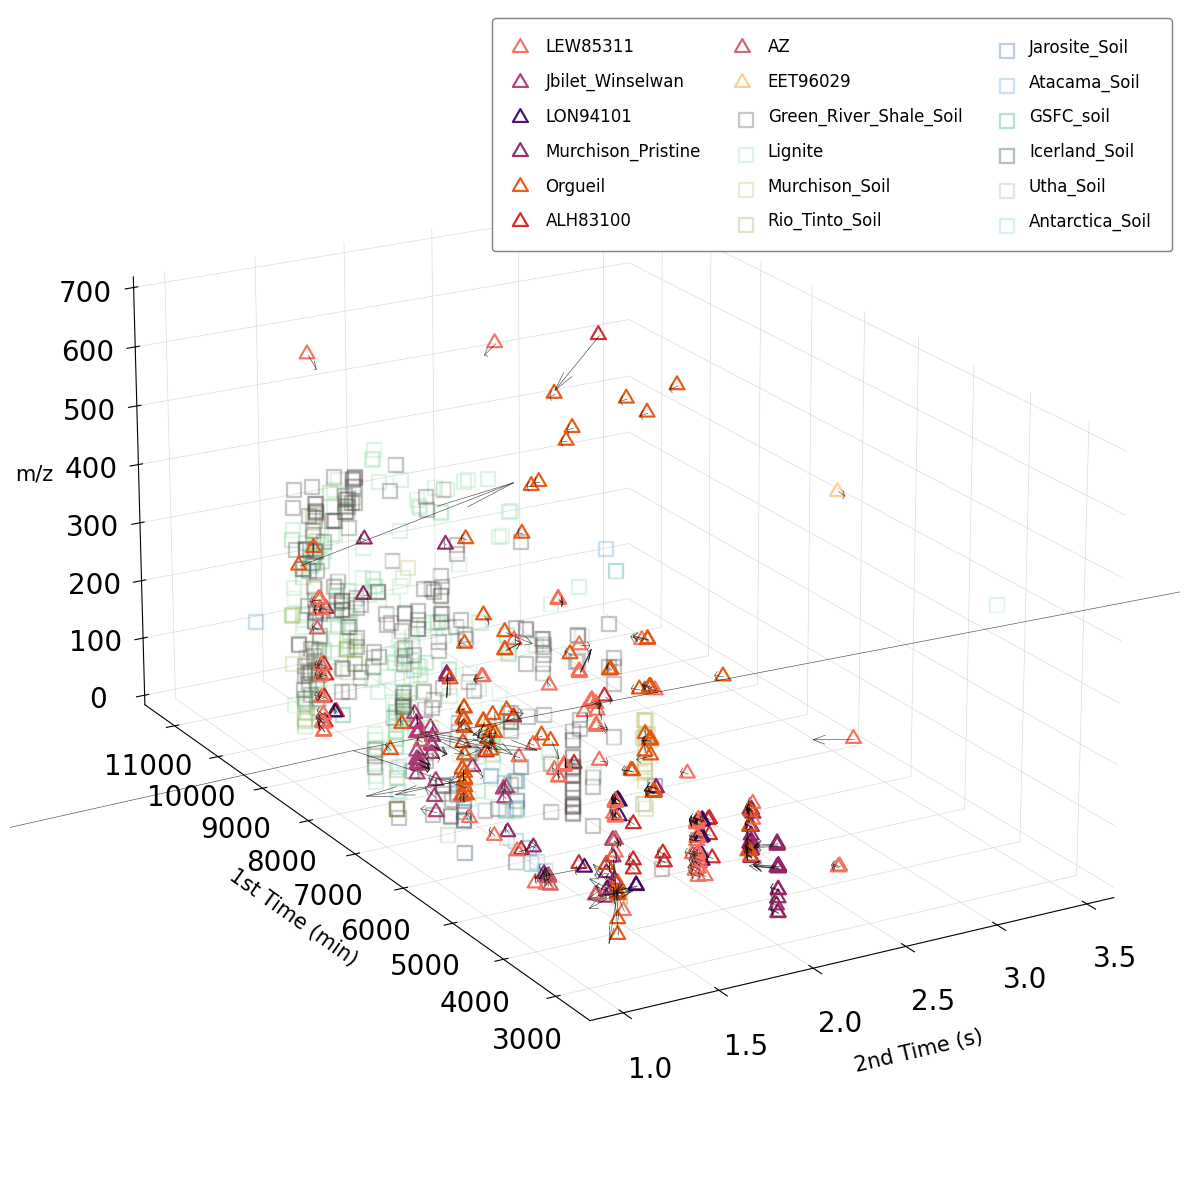

In [11]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.markers import MarkerStyle

def get_marker(svg_path):
    cwd = os.getcwd()
    custom_path, attributes = svg2paths(svg_path)
    marker = parse_path(attributes[0]['d'])
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

def plot_peak_gradients(peaks_features_df, gradients, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = updated_df[updated_df['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'],
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    quiver_scale = 100 if view == "small" else 7
    quiver_kwargs = dict(length=quiver_scale, normalize=True, colors="black", linewidth=0.45, edgecolors='k', alpha=0.7)

    abiotic_df = updated_df[updated_df['class'] == 0]
    ax.quiver(abiotic_df['RT2_center'], abiotic_df['RT1_center'], abiotic_df['m/z'],
              gradients[:, 1], gradients[:, 0], gradients[:, 2],
              **quiver_kwargs)

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    # ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    # ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.savefig('peak_gradients_figure.pdf', dpi=300)
    plt.show()
    plt.close()

df1_updated = df1.copy()
# df1_updated['RT1_center'] = abiotic_peaks_normalized[:, 0]
# df1_updated['RT2_center'] = abiotic_peaks_normalized[:, 1]
# df1_updated['m/z'] = abiotic_peaks_normalized[:, 2]

df2_updated = df2.copy()
# df2_updated['RT1_center'] = biotic_peaks_normalized[:, 0]
# df2_updated['RT2_center'] = biotic_peaks_normalized[:, 1]
# df2_updated['m/z'] = biotic_peaks_normalized[:, 2]

updated_df = pd.concat([df1_updated, df2_updated], axis=0)

plot_peak_gradients(updated_df, gradients_at_time_t[0], '/content/', view='small')

In [311]:
def plot_peaks(peaks_features_df, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = updated_df[updated_df['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'],
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    # ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    # ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.title(result_dir)
    plt.savefig(result_dir)
    # plt.show()
    plt.close()


updated_df1 = df1.copy()
updated_df2 = df2.copy()
# combine
updated_df = pd.concat([updated_df1, updated_df2], axis=0)

# Remove if already exists
import os
import shutil
shutil.rmtree('timesteps', ignore_errors=True)
# Make directory
os.makedirs('timesteps', exist_ok=True)

plot_peaks(updated_df, f'timesteps/0.png', view='small')

for time_step in range(1000):
    updated_df1 = df1.copy()
    updated_df1['RT1_center'] = points_at_time_t[time_step][:, 0]
    updated_df1['RT2_center'] = points_at_time_t[time_step][:, 1]
    updated_df1['m/z'] = points_at_time_t[time_step][:, 2]

    updated_df2 = df2.copy()

    # combine
    updated_df = pd.concat([updated_df1, updated_df2], axis=0)

    plot_peaks(updated_df, f'timesteps/{time_step+1}.png', view='small')

In [315]:
import os
from PIL import Image

# Define the directory containing the images
image_directory = "timesteps/"
output_gif_path = "output.gif"


time_steps = 1000  # Number of images

# Load the images
images = [Image.open(f'{image_directory}{time_step}.png') for time_step in range(time_steps+1)]

# Create the GIF with slow transitions
gif_path = "output.gif"
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=50,  # Duration in milliseconds for each frame
    loop=0
)

print(f"GIF saved to {gif_path}")

GIF saved to output.gif


In [298]:
time_steps

100

In [13]:
import os
# List all files in the directory
path = '/usr/scratch/NASA/results/'
files = os.listdir(path)
files

['230823_01_Atacama_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_02_Rio_Tinto_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_03_Murchison_Pristine_2.0_300uLDCM_100oC24h_Result.csv',
 '230823_04_Murchison_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_05_Antarctica_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_06_Jarosite_Soil_300uLDCM_100oC24h_Result.csv',
 '230823_07_Green_River_Shale_Soil_500uLDCM_100oC24h_Result.csv',
 '230830_01_EET96029_300uLDCM_100oC24h_Result.csv',
 '230830_02_Orgueil_300uLDCM_100oC24h_Result.csv',
 '230830_03_Lignite_300uLDCM_100oC24h_Result.csv',
 '230901_05_GSFC_soil_300uLDCM_100oC24h_Result.csv',
 '230901_06_ALH83100_300uLDCM_100oC24h_Result.csv',
 '230901_07_LON94101_300uLDCM_100oC24h_Result.csv',
 '230901_08_LEW85311_300uLDCM_100oC24h_Result.csv',
 '231003_01_AZ_400uLDCM_100oC24h_Result.csv',
 '231003_01_DCM_Blank_300uLDCM_100oC24h_Result.csv',
 '231003_02_Jbilet_Winselwan_300uLDCM_100oC24h_Result.csv',
 '231003_03_Utha_Soil_300uLDCM_100oC24h_Result.csv',
 '231

In [71]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [90]:
# Function to find similar names
def find_similar_names(df, target_name, column_name='Name', threshold=80):
    results = process.extractBests(target_name, df[column_name], score_cutoff=threshold)
    return pd.DataFrame(results, columns=[column_name, 'score','Another_score'])

In [136]:
import pandas as pd

for file in files:
    # file = '230823_03_Murchison_Pristine_2.0_300uLDCM_100oC24h_Result.csv'
    df = pd.read_csv(path + file, encoding='latin1')

    # Search for rows that contain 'PHENYLNAPHTHALENE'
    # df['name'] = df['Name'].str.upper()

    # similar_names = find_similar_names(df, 'benz(a)anthracene')
    # similar_names = df[(df['Name'].str.contains('Benzophenanthrene'.upper()))]

    mz = 204.27
    similar_names = df[(df['Base Mass'] < mz+0.5) & (df['Base Mass'] > mz-0.5)]

    if len(similar_names) > 0:
        print(f"File: {file} - Similar names:")
        # print(similar_names)
        print('--'*20)

    

File: 230823_07_Green_River_Shale_Soil_500uLDCM_100oC24h_Result.csv - Similar names:
----------------------------------------
File: 230830_02_Orgueil_300uLDCM_100oC24h_Result.csv - Similar names:
----------------------------------------


/tmp/ipykernel_638015/149234174.py:5: DtypeWarning: Columns (9,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file, encoding='latin1')


File: 230830_03_Lignite_300uLDCM_100oC24h_Result.csv - Similar names:
----------------------------------------
File: 230901_08_LEW85311_300uLDCM_100oC24h_Result.csv - Similar names:
----------------------------------------


In [137]:
file = '230901_08_LEW85311_300uLDCM_100oC24h_Result.csv'
df = pd.read_csv(path + file, encoding='latin1')

df[(df['Base Mass'] < mz+0.5) & (df['Base Mass'] > mz-0.5)]

,Name,R.T. (s),Type,Base Mass,Concentration,Sample Concentration,Match,Quant Masses,Quant S/N,Area,...,Observed Ion m/z,Peak Number,Peak S/N,Probability,Similarity,Retention Index,Mass Delta (mDa),Mass Accuracy (ppm),Height,Spectrum
7883,"Tricyclo[8.2.2.2(4,7)]hexadeca-2,4,6,8,10,12,1...","7277.3, 1.956",Unknown,204.0932,NaN,NaN,NaN,BPI(204.093253±5ppm),45.0,43962.0,...,204.0933,2573.0,64.0,NaN,836.0,0.0,-0.03,-0.13,1986.0,61.00867:104.56 62.01516:106.30 69.98661:17.31...
7884,"Tricyclo[8.2.2.2(4,7)]hexadeca-2,4,6,8,10,12,1...","7280.8, 1.952",Unknown,204.0933,NaN,NaN,NaN,BPI(204.093253±5ppm),120.0,164090.0,...,204.0933,2573.0,178.0,NaN,836.0,0.0,-0.03,-0.13,7451.0,61.00867:104.56 62.01516:106.30 69.98661:17.31...
7885,"Tricyclo[8.2.2.2(4,7)]hexadeca-2,4,6,8,10,12,1...","7284.3, 1.944",Unknown,204.0934,NaN,NaN,NaN,BPI(204.093253±5ppm),68.0,100614.0,...,204.0933,2573.0,71.0,NaN,836.0,0.0,-0.03,-0.13,4663.0,61.00867:104.56 62.01516:106.30 69.98661:17.31...
7886,"Tricyclo[8.2.2.2(4,7)]hexadeca-2,4,6,8,10,12,1...","7287.81, 1.945",Unknown,204.0928,NaN,NaN,NaN,BPI(204.093253±5ppm),35.0,42326.0,...,204.0933,2573.0,49.0,NaN,836.0,0.0,-0.03,-0.13,2067.0,61.00867:104.56 62.01516:106.30 69.98661:17.31...
8390,Cyclopenta(def)phenanthrenone,"7494.54, 2.568",Unknown,204.0568,NaN,NaN,NaN,BPI(204.056947±5ppm),268.0,356447.0,...,204.0569,2739.0,597.0,NaN,988.0,0.0,-0.02,-0.09,11530.0,35.99956:10.33 37.00730:24.98 49.00748:20.31 5...
8391,Cyclopenta(def)phenanthrenone,"7498.05, 2.560",Unknown,204.0569,NaN,NaN,NaN,BPI(204.056947±5ppm),520.0,1237104.0,...,204.0569,2739.0,1209.0,NaN,988.0,0.0,-0.02,-0.09,41562.0,35.99956:10.33 37.00730:24.98 49.00748:20.31 5...
8392,Cyclopenta(def)phenanthrenone,"7501.55, 2.560",Unknown,204.0569,NaN,NaN,NaN,BPI(204.056947±5ppm),269.0,592529.0,...,204.0569,2739.0,421.0,NaN,988.0,0.0,-0.02,-0.09,19137.0,35.99956:10.33 37.00730:24.98 49.00748:20.31 5...
8393,Cyclopenta(def)phenanthrenone,"7505.06, 2.552",Unknown,204.0569,NaN,NaN,NaN,BPI(204.056947±5ppm),145.0,248229.0,...,204.0569,2739.0,175.0,NaN,988.0,0.0,-0.02,-0.09,8223.0,35.99956:10.33 37.00730:24.98 49.00748:20.31 5...
8394,Cyclopenta(def)phenanthrenone,"7508.56, 2.472",Unknown,204.0570,NaN,NaN,NaN,BPI(204.056947±5ppm),64.0,111843.0,...,204.0569,2739.0,105.0,NaN,988.0,0.0,-0.02,-0.09,3669.0,35.99956:10.33 37.00730:24.98 49.00748:20.31 5...
8401,Cyclopenta(def)phenanthrenone,"7512.06, 2.560",Unknown,204.0568,NaN,NaN,NaN,BPI(204.056757±5ppm),52.0,74360.0,...,204.0568,2746.0,72.0,NaN,903.0,0.0,0.13,0.64,2478.0,64.01105:125.76 69.08634:167.91 74.01509:261.7...
